# Converting ApRES .DAT files into a single zarr in a google bucket

This notebook uses xapres to load each .DAT file in a given directory and writes it to an individual zarr store in the ldeo-glaciology google bucket. It then writes lazily loads all the zarrs, concatenates them, and writes them to a single zarr store. This notebook should serve as a rough step by step guide on this procedure

First, load the relevant packages and libraries. 

In [1]:
import numpy as np
import os
import gcsfs
import fsspec
import json
import xarray as xr
import sys
sys.path.append("../../xapres_package/")
import ApRESDefs
import zarr
from tqdm.notebook import trange, tqdm
from dask.distributed import performance_report
import matplotlib.pyplot as plt

The following is a function that converts already-saved data in the form of .DAT files into individual zarr files within a folder. You need to define the location where the .DAT files are stored (the directory input in the `dat_file_list` definition, along with the `directory` variable). You also need to define where the individual zarrs are saved (in the `filename` definition inside the loop). This code loops through all the .DAT files in the directory given, and converts each one into an individual zarr and saves it.

The current function is set up to convert winter 2022-2023 season data.

In [23]:
def xapres_to_zarr_chunked(site):  # site can be A101, A103, or A104
    # The same as xapres_to_zarr except that this on prescribes the chunks explicitly 
    xa = ApRESDefs.xapres(max_range=1400)
    dat_file_list = xa.list_files(directory=f'gs://ldeo-glaciology/GL_apres_2022/{site}/winter22_23', 
                remote_load = True)
    #dat_file_list = [k for k in dat_file_list if folder in k] # this line filters to a subfolder

    with open('../../secrets/ldeo-glaciology-bc97b12df06b.json') as token_file:
        token = json.load(token_file)


    directory=f"gs://ldeo-glaciology/GL_apres_2022/{site}/winter22_23'"
    num = 0
    for file in tqdm(dat_file_list,): 
        
        xa = ApRESDefs.xapres(max_range=1400)
        xa.load_all(directory, 
                remote_load = True,
                file_names_to_process=[file])
        filename = f'gs://ldeo-glaciology/apres/greenland/2022/{site}/individual_zarrs_prechunked_winter22_23/dat_{num}' 
        mapper = fsspec.get_mapper(filename, mode='w', token=token)

        ds = xa.data.chunk({'time':1,'attenuator_setting_pair':-1, 'chirp_num':-1, 'profile_range': -1, 'chirp_time':-1  })
        ds.attrs = []
        ds.to_zarr(mapper, consolidated=False)
        
        del xa
        del ds
        num+=1

The next three cells call the above function to convert our winter data. This process takes a while - roughly 10 hours or so for ~250 days of data. Consequently, it could be useful to create a small test directory and follow the whole procedure to make sure it will convert things properly

In [14]:
xapres_to_zarr_chunked("A101")

  0%|          | 0/249 [00:00<?, ?it/s]

In [ ]:
xapres_to_zarr_chunked("A103")

  0%|          | 0/248 [00:00<?, ?it/s]

In [ ]:
xapres_to_zarr_chunked("A104")

  0%|          | 0/128 [00:00<?, ?it/s]

# Loading individual zarrs into one large zarr
Once the individual zarrs have been created, our next step is to combine them all into a single large zarr. We need to first initialize a cluster to help with processing. I set up the cluster to have adaptive scaling, with a maximum worker count of 16, and it seems to be fine.

In [2]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:34147")
client

Connection method: Direct,
Dashboard: /user/glugeorge/proxy/8787/status,
Comm: tcp://127.0.0.1:34147,Workers: 0
Dashboard: /user/glugeorge/proxy/8787/status,Total threads: 0
Started: 20 hours ago,Total memory: 0 B


This function takes all the individual zarrs and combines them into a single zarr. Like the earlier function, you need to specify the directory (this time for the individual zarrs) and filename of the outputted individual zarr.

In [8]:
def zarrs_to_onezarr(site):
    ds = xr.open_mfdataset(f'gs://ldeo-glaciology/apres/greenland/2022/{site}/individual_zarrs_prechunked_winter22_23/dat_*',
                               chunks = {}, 
                               engine = 'zarr', 
                               consolidated = False, 
                               parallel = True)
    #ds['attenuator'] = ds.attenuator[100]
    #ds['AFGain'] = ds.AFGain[100]
        
    for var in ds:
        del ds[var].encoding['chunks']

    profile_stacked = ds.profile.mean(dim='chirp_num')
    ds_stacked = ds.assign({'profile_stacked':profile_stacked})
    ds_stacked_rechunked = ds_stacked.chunk({'time':20})
    
    #encoding = {i: {"dtype": "float64"} for i in ds_stacked_rechunked.data_vars}
    encoding = {
        'time': {
            'units': 'seconds since 1970-01-01'
        }}

    filename = f'gs://ldeo-glaciology/apres/greenland/2022/single_zarrs_noencode/{site}_winter22_23' 
    with open('../../secrets/ldeo-glaciology-bc97b12df06b.json') as token_file:
        token = json.load(token_file)
    mapper = fsspec.get_mapper(filename, mode='w', token=token) 
    with performance_report(f'ds_stacked_rechunked_{site}.html'):
        ds_stacked_rechunked.to_zarr(mapper, consolidated=True, safe_chunks=False, encoding=encoding)

This following block calls the above function and creates the individual zarrs.

In [15]:
zarrs_to_onezarr("A103")
print('done A103')
zarrs_to_onezarr("A104")
print('done A104')


/srv/conda/envs/notebook/lib/python3.10/site-packages/distributed/client.py:3108: UserWarning: Sending large graph of size 36.16 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


done A103
done A104


The remaining code below is uncommented test code used to make sure the uploads were successful.

In [10]:
def reload(site):
    filename = f'gs://ldeo-glaciology/apres/greenland/2022/single_zarrs_noencode/{site}_winter22_23'
    ds = xr.open_dataset(filename,
        engine='zarr', 
        consolidated=True, 
        chunks={}) 
    return ds

def reload_test(site):
    filename = f'gs://ldeo-glaciology/apres/greenland/test/single_zarrs_noencode/{site}'
    ds = xr.open_dataset(filename,
        engine='zarr', 
        consolidated=True, 
        chunks={}) 
    return ds

In [20]:
ds_101 = reload('A104')


In [21]:
ds_101


<xarray.Dataset>
Dimensions:          (attenuator_setting_pair: 2, time: 11202,
                      chirp_time: 40001, chirp_num: 20, profile_range: 6658)
Coordinates:
    AFGain           (attenuator_setting_pair) int64 dask.array<chunksize=(2,), meta=np.ndarray>
    attenuator       (attenuator_setting_pair) float64 dask.array<chunksize=(2,), meta=np.ndarray>
    burst_number     (time) int64 dask.array<chunksize=(1,), meta=np.ndarray>
  * chirp_num        (chirp_num) int64 0 1 2 3 4 5 6 7 ... 13 14 15 16 17 18 19
  * chirp_time       (chirp_time) timedelta64[ns] 00:00:00 ... 00:00:01
    filename         (time) <U75 dask.array<chunksize=(1,), meta=np.ndarray>
  * profile_range    (profile_range) float64 0.0 0.2103 ... 1.4e+03 1.4e+03
  * time             (time) datetime64[ns] 2022-09-25T13:46:34 ... 2023-03-24...
Dimensions without coordinates: attenuator_setting_pair
Data variables:
    battery_voltage  (time) float64 dask.array<chunksize=(20,), meta=np.ndarray>
    chirp            (time, chirp_time, chirp_num, attenuator_setting_pair) float64 dask.array<chunksize=(20, 40001, 20, 2), meta=np.ndarray>
    latitude         (time) float64 dask.array<chunksize=(20,), meta=np.ndarray>
    longitude        (time) float64 dask.array<chunksize=(20,), meta=np.ndarray>
    profile          (time, profile_range, chirp_num, attenuator_setting_pair) complex128 dask.array<chunksize=(20, 6658, 20, 2), meta=np.ndarray>
    profile_stacked  (time, profile_range, attenuator_setting_pair) complex128 dask.array<chunksize=(20, 6658, 2), meta=np.ndarray>
    temperature_1    (time) float64 dask.array<chunksize=(20,), meta=np.ndarray>
    temperature_2    (time) float64 dask.array<chunksize=(20,), meta=np.ndarray>

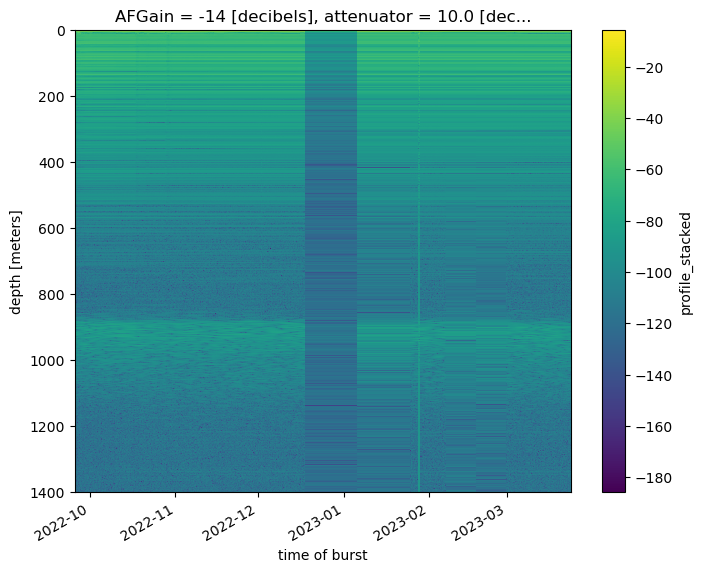

In [22]:
ds = xa.dB(ds_101.profile_stacked.isel(attenuator_setting_pair=1))
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 6))

ds.plot(ax=ax,x='time')
ax.invert_yaxis()